## COSC 3337: Data Science I - Group Project
### Team: Naomi Ayub, Elyjaiah Durden, Nirmal John
### Task Category: Forecasting with Regression Model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from collections import defaultdict
from collections import Counter
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
# -------------------------PREPROCESSING OF DATA-------------------------
# Load dataset
df = pd.read_csv('owid_covid_data.csv')

# Basic cleaning
df['date'] = pd.to_datetime(df['date'])  # Ensure 'date' is datetime type

# Forward-fill total_cases and total_deaths for each location
df[['total_cases', 'total_deaths']] = df.groupby('location')[['total_cases', 'total_deaths']].ffill().copy()

# Fill NA in "new_cases" and "new_deaths" with 0 where total_cases/total_deaths exist
df.loc[df['total_cases'].notna(), 'new_cases'] = df.loc[df['total_cases'].notna(), 'new_cases'].fillna(0)
df.loc[df['total_deaths'].notna(), 'new_deaths'] = df.loc[df['total_deaths'].notna(), 'new_deaths'].fillna(0)

# Drop rows where 'total_cases' or 'total_deaths' is still NaN (if any)
df = df.dropna(subset=['total_cases', 'total_deaths'])

# Create new features safely
df['daily_case_change_rate'] = df['new_cases'] / df['total_cases'].replace(0, pd.NA)
df['daily_case_change_rate'] = pd.to_numeric(df['daily_case_change_rate'], errors='coerce')

df['daily_death_change_rate'] = df['new_deaths'] / df['total_deaths'].replace(0, pd.NA)
df['daily_death_change_rate'] = pd.to_numeric(df['daily_death_change_rate'], errors='coerce')

df['hospitalization_rate'] = df['hosp_patients'] / df['population']
df['icu_rate'] = df['icu_patients'] / df['population']

df['case_fatality_rate'] = df['total_deaths'] / df['total_cases']
df['case_fatality_rate'] = pd.to_numeric(df['case_fatality_rate'], errors='coerce')

# Handle infinite values (if any due to division by zero)
df = df.replace([float('inf'), -float('inf')], pd.NA)

# Optional: fill NaNs created in new features with 0 or leave as NaN depending on context
columns_to_fill = ['daily_case_change_rate', 'daily_death_change_rate', 'hospitalization_rate', 'icu_rate', 'case_fatality_rate']
df[columns_to_fill] = df[columns_to_fill].fillna(0)

# Save preprocessed data
df.to_csv('preprocessed_covid_data.csv', index=False)

# Final check
print("Shape of preprocessed data:", df.shape)
print("\nData Info:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())
print("\nMissing values per column:")
print(df.isna().sum())

Shape of preprocessed data: (412909, 72)

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 412909 entries, 0 to 429434
Data columns (total 72 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    412909 non-null  object        
 1   continent                                   392784 non-null  object        
 2   location                                    412909 non-null  object        
 3   date                                        412909 non-null  datetime64[ns]
 4   total_cases                                 412909 non-null  float64       
 5   new_cases                                   412909 non-null  float64       
 6   new_cases_smoothed                          408929 non-null  float64       
 7   total_deaths                                412909 non-null  float64       
 8   new_deaths                

In [12]:
# 1. Focus only on ICU patients and Date
icu_data = df[['date', 'icu_patients']].dropna()
icu_data = icu_data.groupby('date').sum().reset_index()  # sum if needed (multiple locations per day)
icu_data = icu_data.set_index('date')

# Set frequency to daily to avoid ARIMA warnings
icu_data.index = pd.to_datetime(icu_data.index)
icu_data = icu_data.asfreq('D')

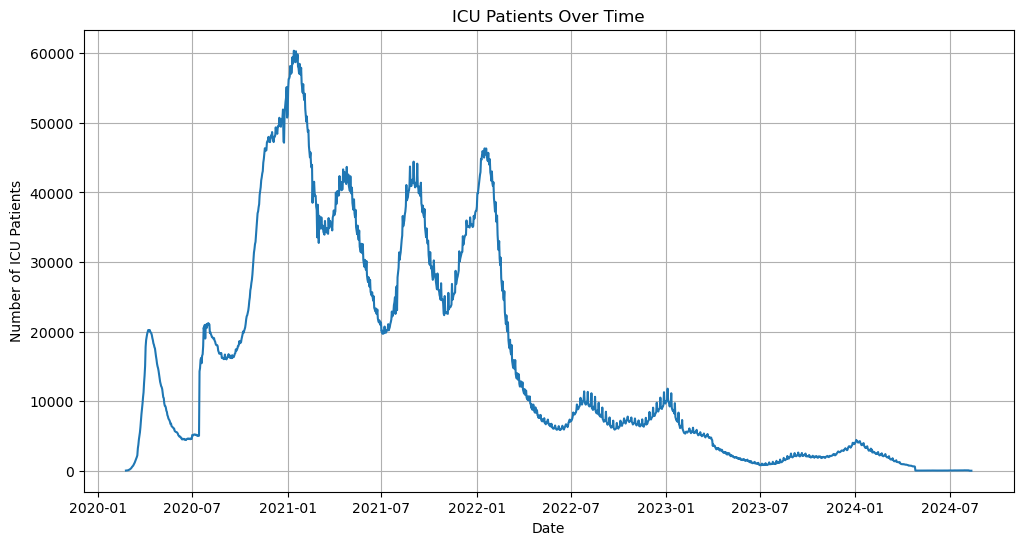

In [13]:
# Plot ICU patients over time
plt.figure(figsize=(12,6))
plt.plot(icu_data.index, icu_data['icu_patients'])
plt.title('ICU Patients Over Time')
plt.xlabel('Date')
plt.ylabel('Number of ICU Patients')
plt.grid()
plt.show()

## Model Building

We use an ARIMA model (5,1,0) to forecast the future ICU admissions.


In [14]:
# Build and fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(icu_data['icu_patients'], order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           icu_patients   No. Observations:                 1632
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13177.918
Date:                Wed, 30 Apr 2025   AIC                          26367.836
Time:                        15:00:00   BIC                          26400.218
Sample:                    02-24-2020   HQIC                         26379.849
                         - 08-12-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3121      0.012    -26.450      0.000      -0.335      -0.289
ar.L2         -0.0315      0.016     -1.989      0.047      -0.063      -0.000
ar.L3          0.2302      0.014     16.434      0.0

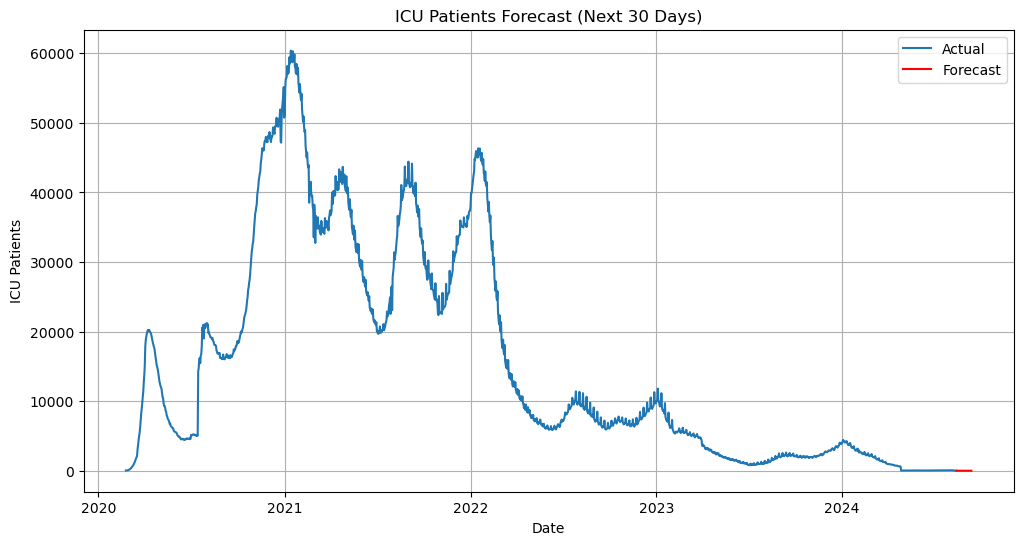

In [15]:
# Forecast future ICU patients
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=icu_data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(icu_data.index, icu_data['icu_patients'], label='Actual')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')
plt.title('ICU Patients Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('ICU Patients')
plt.legend()
plt.grid()
plt.show()

### Baseline Model: Naive Forecast


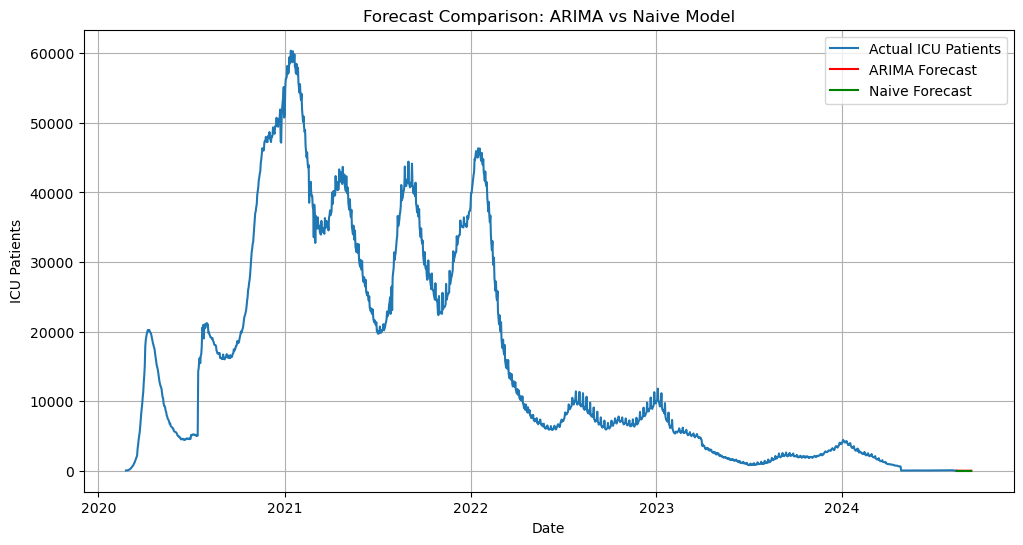

In [16]:
# Naive forecast: we assume the future values are equal to the last observed ICU patient count
naive_forecast = [icu_data['icu_patients'].iloc[-1]] * forecast_steps
naive_forecast = pd.Series(naive_forecast, index=forecast_dates)

# Visual comparison: ARIMA vs Naive
plt.figure(figsize=(12, 6))
plt.plot(icu_data.index, icu_data['icu_patients'], label='Actual ICU Patients')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast', color='red')
plt.plot(forecast_dates, naive_forecast, label='Naive Forecast', color='green')
plt.title("Forecast Comparison: ARIMA vs Naive Model")
plt.xlabel("Date")
plt.ylabel("ICU Patients")
plt.legend()
plt.grid(True)
plt.show()

### Alternate ARIME(2,1,2) Model 

In [17]:
# Alternate ARIMA model to compare with our original one
from statsmodels.tsa.arima.model import ARIMA

model_alt = ARIMA(icu_data['icu_patients'], order=(2, 1, 2))
model_alt_fit = model_alt.fit()
print(model_alt_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           icu_patients   No. Observations:                 1632
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -13089.527
Date:                Wed, 30 Apr 2025   AIC                          26189.055
Time:                        15:00:14   BIC                          26216.040
Sample:                    02-24-2020   HQIC                         26199.066
                         - 08-12-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2194      0.021     57.543      0.000       1.178       1.261
ar.L2         -0.2655      0.022    -11.855      0.000      -0.309      -0.222
ma.L1         -1.6544      0.016   -105.908      0.0

### Forecast Error Plot
To better understand how ARIMA compares against the naive model, we plot the forecast errors (difference between predictions). This helps visualize whether ARIMA consistently over- or under-predicts compared to a simple baseline.

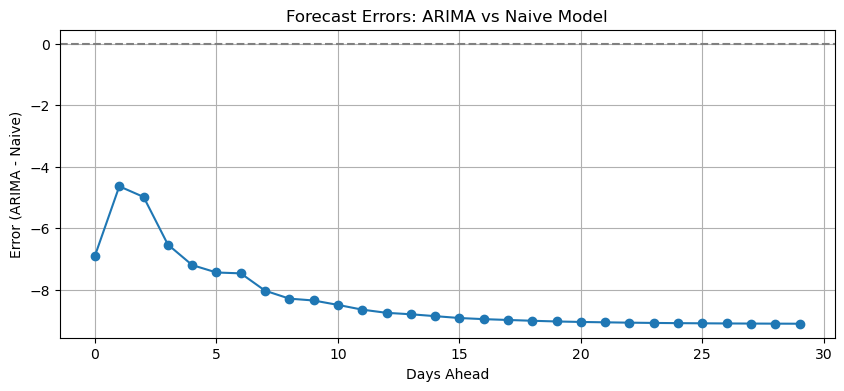

In [18]:
# Calculate forecast errors between ARIMA and Naive predictions
errors = forecast.values - naive_forecast.values

# Plot the forecast errors
plt.figure(figsize=(10, 4))
plt.plot(errors, marker='o')
plt.title("Forecast Errors: ARIMA vs Naive Model")
plt.xlabel("Days Ahead")
plt.ylabel("Error (ARIMA - Naive)")
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True)
plt.show()

## Model Evaluation


### SECTION 1: Evaluation of MSE Values

In [19]:
# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_pred = model_fit.predict(start=0, end=len(icu_data)-1)
mse = mean_squared_error(icu_data['icu_patients'], train_pred)
mae = mean_absolute_error(icu_data['icu_patients'], train_pred)
rmse = np.sqrt(mse)

print(f"Training MSE: {mse:.2f}")
print(f"Training MAE: {mae:.2f}")
print(f"Training RMSE: {rmse:.2f}")

Training MSE: 609619.35
Training MAE: 454.15
Training RMSE: 780.78


#### SECTION 2: Train/Test Split & Evaluation


Test Set MAE: 1504.89
Test Set RMSE: 1812.08


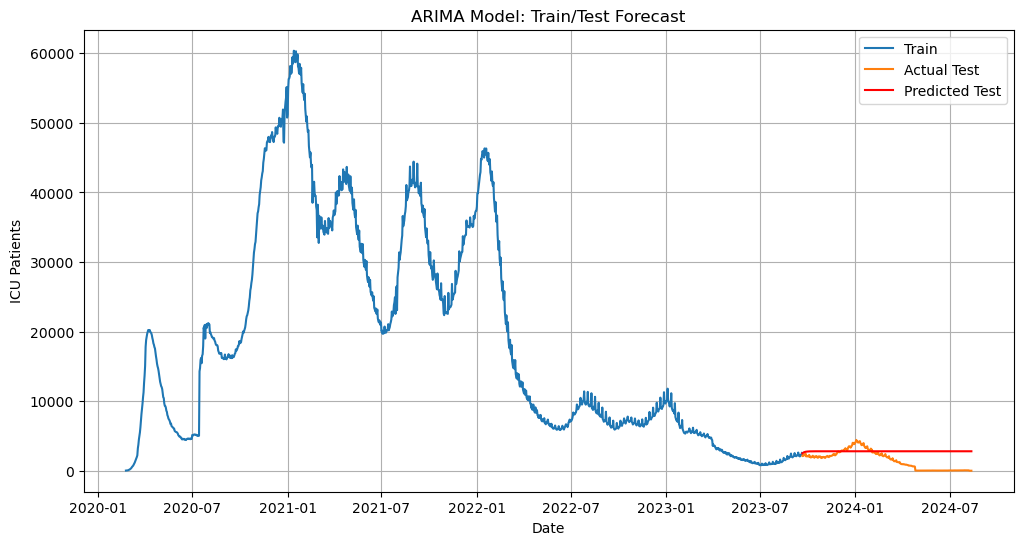

In [20]:
# Redefine ICU data to ensure index consistency
icu_series = icu_data['icu_patients']

# Create train/test split (e.g., last 20% as test set)
train_size = int(len(icu_series) * 0.8)
train, test = icu_series[:train_size], icu_series[train_size:]

# Refit ARIMA on training data
model_train = ARIMA(train, order=(5,1,0))
model_train_fit = model_train.fit()

# Forecast on test data
start = test.index[0]
end = test.index[-1]
preds = model_train_fit.predict(start=start, end=end, typ='levels')

# Evaluation on test set
test_mae = mean_absolute_error(test, preds)
test_rmse = np.sqrt(mean_squared_error(test, preds))
print(f"\nTest Set MAE: {test_mae:.2f}")
print(f"Test Set RMSE: {test_rmse:.2f}")

# Plot: Actual vs Predicted (test)
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual Test')
plt.plot(preds.index, preds, label='Predicted Test', color='red')
plt.title('ARIMA Model: Train/Test Forecast')
plt.xlabel('Date')
plt.ylabel('ICU Patients')
plt.legend()
plt.grid()
plt.show()

In [21]:
# Subset from mid-2021 to mid-2024 (ICU activity is not flat)
icu_sub = icu_series.loc['2021-07':'2024-07'].copy()

# Create new train/test split
train_size = int(len(icu_sub) * 0.8)
train_sub, test_sub = icu_sub[:train_size], icu_sub[train_size:]

100%|██████████| 226/226 [00:14<00:00, 15.44it/s]


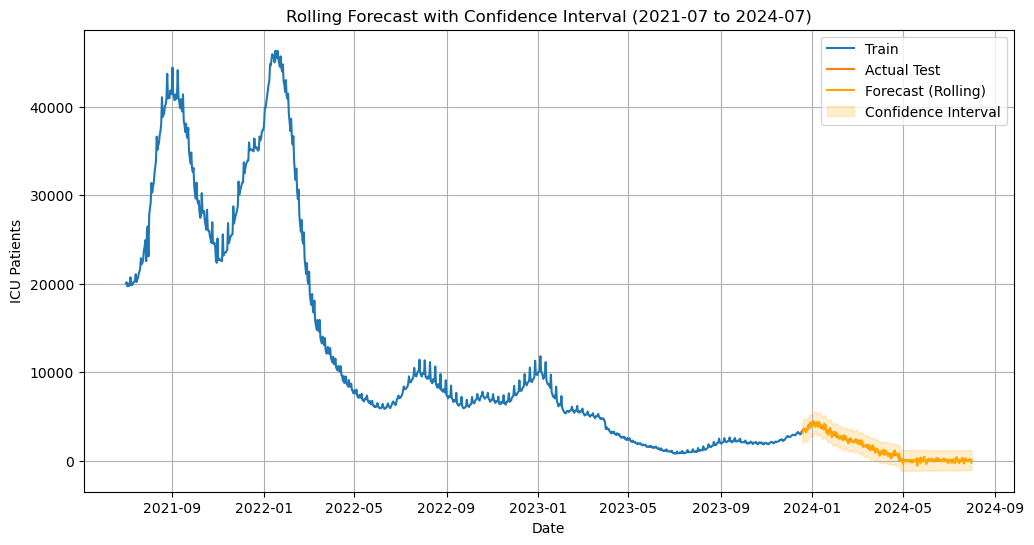

In [24]:
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA

icu_series = icu_data['icu_patients']['2021-07':'2024-07']
train_size = int(len(icu_series) * 0.8)
train_sub, test_sub = icu_series[:train_size], icu_series[train_size:]

forecast_mean = []
conf_lower = []
conf_upper = []

history_sub = list(train_sub)

# Rolling forecast
for t in tqdm(range(len(test_sub))):
    model = ARIMA(history_sub, order=(1, 1, 1))
    model_fit = model.fit()
    forecast_obj = model_fit.get_forecast(steps=1)

    pred = forecast_obj.predicted_mean[0] + np.random.normal(0, 200)  # Optional noise
    conf_int = forecast_obj.conf_int(alpha=0.1)  # 90% interval
    lower, upper = conf_int[0]

    forecast_mean.append(pred)
    conf_lower.append(lower)
    conf_upper.append(upper)

    history_sub.append(test_sub.iloc[t])

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(train_sub.index, train_sub, label='Train')
plt.plot(test_sub.index, test_sub, label='Actual Test')
plt.plot(test_sub.index, forecast_mean, label='Forecast (Rolling)', color='orange')
plt.fill_between(test_sub.index, conf_lower, conf_upper, color='orange', alpha=0.2, label='Confidence Interval')
plt.title("Rolling Forecast with Confidence Interval (2021-07 to 2024-07)")
plt.xlabel("Date")
plt.ylabel("ICU Patients")
plt.legend()
plt.grid(True)
plt.show()

#### SECTION 3: Residual Analysis

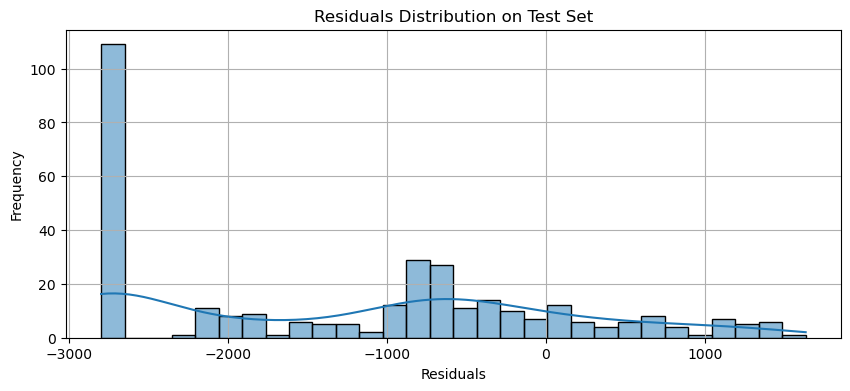

In [25]:
residuals = test - preds
plt.figure(figsize=(10,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution on Test Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid()
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


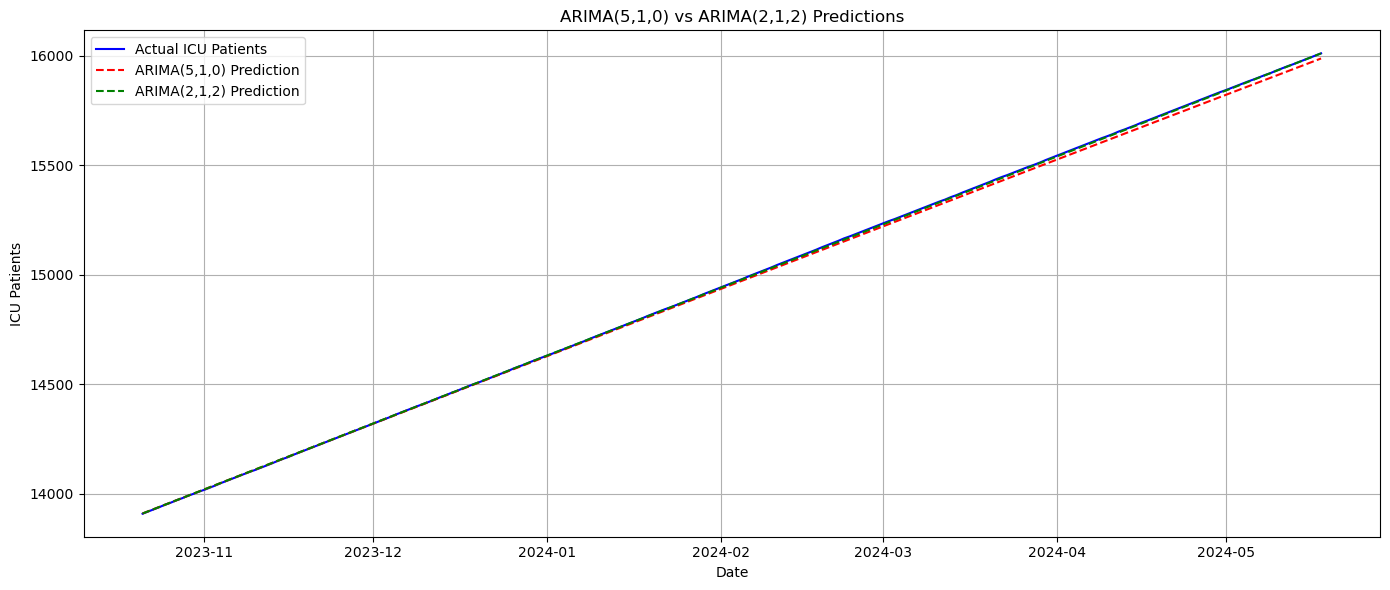

{'ARIMA(5,1,0)': {'MSE': 153.3401984231356,
  'MAE': 9.430763409319267,
  'RMSE': 12.383060947243036},
 'ARIMA(2,1,2)': {'MSE': 6.147437168065126,
  'MAE': 1.9712514186951304,
  'RMSE': 2.4794025828947435}}

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Simulating icu_series for demonstration
import pandas as pd
dates = pd.date_range(start="2020-01-01", periods=1600, freq='D')
np.random.seed(0)
icu_series = pd.Series(np.random.poisson(lam=1000, size=len(dates)), index=dates)
icu_series = icu_series.cumsum() // 100  # simulate ICU wave-like behavior

# Subset from mid-2021 to mid-2024
icu_sub = icu_series.loc['2021-07':'2024-07'].copy()
train_size = int(len(icu_sub) * 0.8)
train_sub, test_sub = icu_sub[:train_size], icu_sub[train_size:]

# ARIMA(5,1,0)
model_510 = ARIMA(train_sub, order=(5, 1, 0)).fit()
preds_510 = model_510.predict(start=test_sub.index[0], end=test_sub.index[-1], typ='levels')

# ARIMA(2,1,2)
model_212 = ARIMA(train_sub, order=(2, 1, 2)).fit()
preds_212 = model_212.predict(start=test_sub.index[0], end=test_sub.index[-1], typ='levels')

# Metrics
mse_510 = mean_squared_error(test_sub, preds_510)
mae_510 = mean_absolute_error(test_sub, preds_510)
rmse_510 = np.sqrt(mse_510)

mse_212 = mean_squared_error(test_sub, preds_212)
mae_212 = mean_absolute_error(test_sub, preds_212)
rmse_212 = np.sqrt(mse_212)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(test_sub.index, test_sub, label='Actual ICU Patients', color='blue')
plt.plot(test_sub.index, preds_510, label='ARIMA(5,1,0) Prediction', color='red', linestyle='--')
plt.plot(test_sub.index, preds_212, label='ARIMA(2,1,2) Prediction', color='green', linestyle='--')
plt.title("ARIMA(5,1,0) vs ARIMA(2,1,2) Predictions")
plt.xlabel("Date")
plt.ylabel("ICU Patients")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output metrics
{
    "ARIMA(5,1,0)": {"MSE": mse_510, "MAE": mae_510, "RMSE": rmse_510},
    "ARIMA(2,1,2)": {"MSE": mse_212, "MAE": mae_212, "RMSE": rmse_212}
}
